In [1]:
# %pip install autogluon

In [2]:
import os
import time

import numpy as np
import pandas as pd
from autogluon.tabular import TabularPredictor
from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

Setting rules for libraries

In [3]:
# Warnings

# Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

# Reading files

In [4]:
# Features to remove
DATE_CALC: str = "date_calc"
DATE_FORECAST: str = "date_forecast"
ABSOLUTE_HUMIDITY: str = 'absolute_humidity_2m:gm3'
AIR_DENSITY: str = 'air_density_2m:kgm3'
CEILING_HEIGHT: str = 'ceiling_height_agl:m'
CLEAR_SKY_ENERGY: str = 'clear_sky_energy_1h:J'
CLEAR_SKY_RAD: str = 'clear_sky_rad:W'
CLOUD_BASE: str = 'cloud_base_agl:m'
DEW_OR_RIME: str = 'dew_or_rime:idx'
DEW_POINT: str = 'dew_point_2m:K'
DIFFUSE_RAD: str = 'diffuse_rad:W'
DIFFUSE_RAD_1H: str = 'diffuse_rad_1h:J'
DIRECT_RAD: str = 'direct_rad:W'
DIRECT_RAD_1H: str = 'direct_rad_1h:J'
EFFECTIVE_CLOUD_COVER: str = 'effective_cloud_cover:p'
ELEVATION: str = 'elevation:m'
FRESH_SNOW_12H: str = 'fresh_snow_12h:cm'
FRESH_SNOW_1H: str = 'fresh_snow_1h:cm'
FRESH_SNOW_24H: str = 'fresh_snow_24h:cm'
FRESH_SNOW_3H: str = 'fresh_snow_3h:cm'
FRESH_SNOW_6H: str = 'fresh_snow_6h:cm'
IS_DAY: str = 'is_day:idx'
IS_IN_SHADOW: str = 'is_in_shadow:idx'
MSL_PRESSURE: str = 'msl_pressure:hPa'
PRECIP_5MIN: str = 'precip_5min:mm'
PRECIP_TYPE_5MIN: str = 'precip_type_5min:idx'
PRESSURE_100M: str = 'pressure_100m:hPa'
PRESSURE_50M: str = 'pressure_50m:hPa'
PROB_RIME: str = 'prob_rime:p'
RAIN_WATER: str = 'rain_water:kgm2'
RELATIVE_HUMIDITY: str = 'relative_humidity_1000hPa:p'
SFC_PRESSURE: str = 'sfc_pressure:hPa'
SNOW_DENSITY: str = 'snow_density:kgm3'
SNOW_DEPTH: str = 'snow_depth:cm'
SNOW_DRIFT: str = 'snow_drift:idx'
SNOW_MELT_10MIN: str = 'snow_melt_10min:mm'
SNOW_WATER: str = 'snow_water:kgm2'
SUN_AZIMUTH: str = 'sun_azimuth:d'
SUN_ELEVATION: str = 'sun_elevation:d'
SUPER_COOLED_LIQUID_WATER: str = 'super_cooled_liquid_water:kgm2'
T_1000HPA: str = 't_1000hPa:K'
TOTAL_CLOUD_COVER: str = 'total_cloud_cover:p'
VISIBILITY: str = 'visibility:m'
WIND_SPEED_10M: str = 'wind_speed_10m:ms'
WIND_SPEED_U_10M: str = 'wind_speed_u_10m:ms'
WIND_SPEED_V_10M: str = 'wind_speed_v_10m:ms'
WIND_SPEED_W_1000HPA: str = 'wind_speed_w_1000hPa:ms'
IS_ESTIMATED = 'is_estimated'

TIME = 'time'
PV_MEASUREMENT = 'pv_measurement'

In [5]:
# Functions
def read_parquet(filepath: str) -> pd.DataFrame:
    dataframe: pd.DataFrame = pd.read_parquet(filepath)
    if DATE_CALC in dataframe.columns:
        dataframe = dataframe.drop(columns=[DATE_CALC])

    return dataframe


def concat_observed_and_estimated_train_data(
        X_observed: pd.DataFrame,
        X_estimated: pd.DataFrame
) -> pd.DataFrame:
    X_observed: pd.DataFrame = X_observed.copy()
    X_estimated: pd.DataFrame = X_estimated.copy()

    assert X_observed.shape[1] == X_estimated.shape[1]

    concatenated_dataframe: pd.DataFrame = pd.concat(
        objs=[X_observed, X_estimated],
        axis=0
    ).sort_values(
        by=DATE_FORECAST,
        ascending=True
    ).reset_index(drop=True)

    return concatenated_dataframe

In [6]:
# Data transfer object for location data
class LocationData:
    combined_data: pd.DataFrame

    def __init__(self, train_data, target_data, test_data) -> None:
        self.train_data = train_data
        self.target_data = target_data
        self.test_data = test_data

        self.original_train_data = train_data.copy()
        self.original_target_data = target_data.copy()
        self.original_test_data = test_data.copy()

    def __repr__(self) -> str:
        return f"Train: {self.train_data.shape} [No. NaN: {self.train_data.isna().sum().sum()}], Target: {self.target_data.shape} [No. NaN: {self.target_data.isna().sum().sum()}], Test: {self.test_data.shape} [No. NaN: {self.test_data.isna().sum().sum()}]"

In [7]:
observed_train = read_parquet("data/A/X_train_observed.parquet")
estimated_train = read_parquet("data/A/X_train_estimated.parquet")
target_data = read_parquet("data/A/train_targets.parquet")
test_data = read_parquet("data/A/X_test_estimated.parquet")

observed_train['is_estimated'] = 0
estimated_train['is_estimated'] = 1
test_data['is_estimated'] = 1

train_data = concat_observed_and_estimated_train_data(
    X_observed=observed_train,
    X_estimated=estimated_train
)

In [8]:
A = LocationData(
    train_data=train_data,
    target_data=target_data,
    test_data=test_data
)

In [9]:
observed_train = read_parquet("data/B/X_train_observed.parquet")
estimated_train = read_parquet("data/B/X_train_estimated.parquet")
target_data = read_parquet("data/B/train_targets.parquet")
test_data = read_parquet("data/B/X_test_estimated.parquet")

observed_train['is_estimated'] = 0
estimated_train['is_estimated'] = 1
test_data['is_estimated'] = 1

train_data = concat_observed_and_estimated_train_data(
    X_observed=observed_train,
    X_estimated=estimated_train
)

B = LocationData(
    train_data=train_data,
    target_data=target_data,
    test_data=test_data
)

In [10]:
observed_train = read_parquet("data/C/X_train_observed.parquet")
estimated_train = read_parquet("data/C/X_train_estimated.parquet")
target_data = read_parquet("data/C/train_targets.parquet")
test_data = read_parquet("data/C/X_test_estimated.parquet")

observed_train['is_estimated'] = 0
estimated_train['is_estimated'] = 1
test_data['is_estimated'] = 1

train_data = concat_observed_and_estimated_train_data(
    X_observed=observed_train,
    X_estimated=estimated_train
)

In [11]:
C = LocationData(
    train_data=train_data,
    target_data=target_data,
    test_data=test_data
)

In [12]:
display(A)
display(B)
display(C)

Train: (136245, 47) [No. NaN: 168040], Target: (34085, 2) [No. NaN: 0], Test: (2880, 47) [No. NaN: 3971]

Train: (134505, 47) [No. NaN: 158811], Target: (32848, 2) [No. NaN: 4], Test: (2880, 47) [No. NaN: 3912]

Train: (134401, 47) [No. NaN: 157326], Target: (32155, 2) [No. NaN: 6060], Test: (2880, 47) [No. NaN: 4104]

# Preprocessing
## Defining functions for preprocessing

Function to remove features and replace `NaN` values with zero

In [13]:
def remove_feature(dataframe: pd.DataFrame, *features: str) -> pd.DataFrame:
    dataframe = dataframe.drop(columns=[*features])
    return dataframe


def replace_nan_with_zero(dataframe: pd.DataFrame, feature: str) -> pd.DataFrame:
    dataframe = dataframe.copy()
    dataframe[[feature]] = dataframe[[feature]].fillna(0)
    return dataframe

Function to resample data by categorizing them
- Features to average
- Features to pick a value
- Features to change redefine `NaN`.

In [14]:
def sample_by_selection(dataframe: pd.DataFrame, *features: str) -> pd.DataFrame:
    reduced_dataframe = dataframe[[*features]]
    if reduced_dataframe.isna().sum().sum() > 0:
        print("[ERROR] Sample by selection got dataframe with NaN values")

    resampler = reduced_dataframe.resample('H')
    reduced_dataframe = resampler.last()

    return reduced_dataframe


def sample_by_mean(dataframe: pd.DataFrame, *features: str) -> pd.DataFrame:
    reduced_dataframe = dataframe[[*features]]

    resampler = reduced_dataframe.resample('H')
    reduced_dataframe = resampler.mean()
    
    return reduced_dataframe


def sample_by_sum(dataframe: pd.DataFrame, *features: str) -> pd.DataFrame:
    reduced_dataframe = dataframe[[*features]]

    resampler = reduced_dataframe.resample('H')
    reduced_dataframe = resampler.sum()

    return reduced_dataframe


def sample_cloud_base(dataframe: pd.DataFrame) -> pd.DataFrame:
    cloud_base_frame = dataframe[[CLOUD_BASE]]

    # Filling NaN values with -2_000
    filled_frame = cloud_base_frame.copy()
    filled_frame = filled_frame.fillna(-100_000)

    # Resampling to 1H
    resampler = filled_frame.resample('H')
    cloud_base_frame = resampler.mean()

    # Replacing negative values with -666
    cloud_bases = cloud_base_frame[CLOUD_BASE].to_numpy()
    negative_indexes = np.where(cloud_bases < 0)[0]
    cloud_bases[negative_indexes] = -666
    cloud_base_frame[CLOUD_BASE] = cloud_bases

    # Dropping NaN values that were introduced by resampling
    reduced_dataframe = cloud_base_frame.copy()

    return reduced_dataframe


def merge_frames(*dataframes: pd.DataFrame) -> pd.DataFrame:
    indexes = [df.index for df in dataframes]

    # Finding intersecting indexes in list of indexes, the indexes are datetime
    intersecting_indexes = list(set(indexes[0]).intersection(*indexes))
    filtered_dataframes = [df.loc[intersecting_indexes] for df in dataframes]

    return pd.concat(filtered_dataframes, axis=1)

Functions to synchronze dates in weather data and target data

In [15]:
def synchronize_timestamps(train_data: pd.DataFrame, target_data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    # IndexError if index in both train data and target data is DateTimeIndex
    if not isinstance(train_data.index, pd.DatetimeIndex):
        raise IndexError("Train data does not have DateTimeIndex")

    if not isinstance(target_data.index, pd.DatetimeIndex):
        raise IndexError("Target data does not have DateTimeIndex")

    train_data.sort_index(inplace=True)
    target_data.sort_index(inplace=True)

    train_dates = train_data.index.values
    target_dates = target_data.index.values

    # Finding intersecting dates and filtering dataframes
    intersecting_dates = np.intersect1d(train_dates, target_dates)
    train_data = train_data.loc[intersecting_dates]
    target_data = target_data.loc[intersecting_dates]

    return train_data, target_data


The dateset contains many constant values for some features, any row with constant values is removed. If there is are at least 24 rows with constant values, the rows are removed.
- -666 in cloud base should not be removed as this is added in earlier 

In [16]:
def remove_constant_measurements(
        train_data: pd.DataFrame,
        target_data: pd.DataFrame,
        THRESHOLD: int = 24
) -> tuple[pd.DataFrame, pd.DataFrame]:
    indexes = []
    count = 0
    previous_value = None
    start_index = None

    # Setting date indexes as columns and resetting index
    train_data[DATE_FORECAST] = train_data.index.values
    target_data[TIME] = target_data.index.values

    train_data.reset_index(drop=True, inplace=True)
    target_data.reset_index(drop=True, inplace=True)

    # Assuming y is a DataFrame and has a column for pv_measurement values
    pv_measurements = target_data[PV_MEASUREMENT].to_numpy()

    # Identifying indexes of consecutive constant values
    for index, value in enumerate(pv_measurements):
        if value == previous_value:
            count += 1
            if count == 1:
                start_index = index - 1
            if count >= THRESHOLD and value > -0.1:
                indexes.extend(range(start_index, index + 1))
        else:
            count = 0
        previous_value = value

    # Assuming y has a column for dates and X has a similar column to filter on
    dates = target_data.loc[indexes, TIME].unique()

    filtered_train_data = train_data[~train_data[DATE_FORECAST].isin(dates)]
    filtered_target_data = target_data[~target_data[TIME].isin(dates)]

    # Switching back to date as index
    filtered_train_data = filtered_train_data.set_index(DATE_FORECAST)
    filtered_target_data = filtered_target_data.set_index(TIME)

    return filtered_train_data, filtered_target_data


def drop_nan_values_from_target_data(train_data: pd.DataFrame, target_data: pd.DataFrame) -> tuple[
    pd.DataFrame, pd.DataFrame]:
    target_data.dropna(axis=0, how='any', inplace=True)
    train_data, target_data = synchronize_timestamps(train_data, target_data)
    return train_data, target_data


## Adding lag features, this has to come here because of the resampling

In [17]:
def add_lag_features(dataframe: pd.DataFrame, features: list[str], lags: list[int]) -> tuple[pd.DataFrame, list[str]]:
    dataframe = dataframe.copy()
    lag_feature_names: list[str] = []
    for feature in features:
        for lag in lags:
            lag_feature_name = f"{feature}_lag_{lag}"
            dataframe[lag_feature_name] = dataframe[feature].shift(lag)
            lag_feature_names.append(lag_feature_name)

    return dataframe, lag_feature_names


def add_lead_features(dataframe: pd.DataFrame, features: list[str], lags: list[int]) -> tuple[pd.DataFrame, list[str]]:
    dataframe = dataframe.copy()
    lead_feature_names: list[str] = []
    for feature in features:
        for lag in lags:
            lead_feature_name = f"{feature}_lead_{lag}"
            dataframe[lead_feature_name] = dataframe[feature].shift(-lag)
            lead_feature_names.append(lead_feature_name)

    return dataframe, lead_feature_names

Pipeline for preprocessing that is common for both train and test data

In [18]:
def common_pre_processing(dataframe: pd.DataFrame, is_cat_boost: bool) -> pd.DataFrame:
    features_to_drop = [SNOW_DRIFT, CEILING_HEIGHT, SNOW_DENSITY]
    
    if is_cat_boost: 
        dataframe = remove_feature(dataframe, *features_to_drop)

    dataframe = dataframe.set_index(DATE_FORECAST)
    feature_to_lag_and_lead: list[str] = [DIRECT_RAD]

    # Adding lag and lead features
    lag_features = []
    lead_features = []

    if is_cat_boost:
        dataframe, lag_features = add_lag_features(dataframe, feature_to_lag_and_lead, [1, 2, 3])
        dataframe, lead_features = add_lead_features(dataframe, feature_to_lag_and_lead, [1, 2, 3])

    # Resample data to hours
    selection_features = [
        CLEAR_SKY_ENERGY,  # Maybe move
        DIRECT_RAD_1H,  # MAYBE MOVE
        DIFFUSE_RAD_1H,  # Maybe move
        FRESH_SNOW_1H,
        FRESH_SNOW_3H,
        FRESH_SNOW_6H,
        FRESH_SNOW_12H,
        FRESH_SNOW_24H,
        DEW_OR_RIME,
        IS_DAY,
        IS_IN_SHADOW,
        PRECIP_TYPE_5MIN,
        ELEVATION,
        IS_ESTIMATED,
        *lag_features,
        *lead_features,
    ]

    mean_features = [
        ABSOLUTE_HUMIDITY,
        CLEAR_SKY_RAD,
        DIFFUSE_RAD,
        DIRECT_RAD,
        AIR_DENSITY,
        DEW_POINT,
        MSL_PRESSURE,
        PRESSURE_100M,
        PRESSURE_50M,
        SFC_PRESSURE,
        RELATIVE_HUMIDITY,
        T_1000HPA,
        SUN_AZIMUTH,
        SUN_ELEVATION,
        EFFECTIVE_CLOUD_COVER,
        TOTAL_CLOUD_COVER,
        VISIBILITY,
        WIND_SPEED_10M,
        WIND_SPEED_U_10M,
        WIND_SPEED_V_10M,
        WIND_SPEED_W_1000HPA,
        SNOW_MELT_10MIN,
        PROB_RIME,
        SUPER_COOLED_LIQUID_WATER,
        SNOW_DEPTH, 
    ]
    
    sum_features = [
        SNOW_WATER,
        PRECIP_5MIN,
        RAIN_WATER,
    ]
    
    if not is_cat_boost:
        for feature in features_to_drop:
            mean_features.append(feature)

    selection_df = sample_by_selection(dataframe, *selection_features)
    mean_df = sample_by_mean(dataframe, *mean_features)
    sum_df = sample_by_sum(dataframe, *sum_features)
    ceiling_height_df = sample_cloud_base(dataframe)
    dataframe = merge_frames(selection_df, mean_df, ceiling_height_df, sum_df)

    if is_cat_boost:
        dataframe = dataframe.dropna(axis=0, how='any')

    return dataframe

### Preprocessing pipelines for train and test data

In [19]:
def pre_process_train_data(
        train_data: pd.DataFrame, 
        target_data: pd.DataFrame, 
        is_cat_boost: bool
) -> tuple[pd.DataFrame, pd.DataFrame]:
    train_data = common_pre_processing(dataframe=train_data, is_cat_boost=is_cat_boost)

    # Setting time as index for target data
    target_data[TIME] = pd.to_datetime(target_data[TIME])
    target_data = target_data.set_index(TIME)

    # Preprocessing that affects both train and target data
    train_data, target_data = synchronize_timestamps(train_data=train_data, target_data=target_data)
    train_data, target_data = remove_constant_measurements(train_data=train_data, target_data=target_data)
    train_data, target_data = drop_nan_values_from_target_data(train_data=train_data, target_data=target_data)

    return train_data, target_data


def pre_process_test_data(test_data: pd.DataFrame, is_cat_boost: bool) -> pd.DataFrame:
    if is_cat_boost:
        test_data = common_pre_processing(dataframe=test_data, is_cat_boost=is_cat_boost)
    else:
        test_data = test_data.set_index(DATE_FORECAST)
        test_data = test_data.groupby(test_data.index.floor('H')).mean()

    return test_data

# AutoGluon

In [20]:
train_data, target_data = pre_process_train_data(
    train_data=A.train_data,
    target_data=A.target_data,
    is_cat_boost=False
)

test_data = pre_process_test_data(test_data=A.test_data, is_cat_boost=False)
A.train_data = train_data
A.target_data = target_data
A.test_data = test_data

In [21]:
train_data, target_data = pre_process_train_data(
    train_data=B.train_data,
    target_data=B.target_data,
    is_cat_boost=False
)
test_data = pre_process_test_data(test_data=B.test_data, is_cat_boost=False)
B.train_data = train_data
B.target_data = target_data
B.test_data = test_data

In [22]:
train_data, target_data = pre_process_train_data(
    train_data=C.train_data,
    target_data=C.target_data,
    is_cat_boost=False
)
test_data = pre_process_test_data(test_data=C.test_data, is_cat_boost=False)
C.train_data = train_data
C.target_data = target_data
C.test_data = test_data

In [23]:
display(A)
display(B)
display(C)

Train: (34042, 46) [No. NaN: 40037], Target: (34042, 1) [No. NaN: 0], Test: (720, 46) [No. NaN: 978]

Train: (25899, 46) [No. NaN: 30105], Target: (25899, 1) [No. NaN: 0], Test: (720, 46) [No. NaN: 965]

Train: (21135, 46) [No. NaN: 26480], Target: (21135, 1) [No. NaN: 0], Test: (720, 46) [No. NaN: 1010]

In [24]:
MINUTES: int = 1
time_limit = int(60 * MINUTES)

In [25]:
# Merged files required by the AutoGluon model
def merge_train_and_target(location: LocationData) -> pd.DataFrame:
    train_data = location.train_data.copy()
    target_data = location.target_data.copy()

    return pd.merge(left=train_data, right=target_data, left_index=True, right_index=True, how='inner')


def prepare_data_for_ag(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    for col in dataframe.columns:
        if dataframe[col].dtype == 'object':
            dataframe[col] = dataframe[col].astype(str)
        else:
            dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce')
    """

    if pd.api.types.is_datetime64_any_dtype(dataframe.index):
        dataframe = dataframe.sort_index()  # Sort by date if the index is a datetime
        dataframe = dataframe.reset_index()  # Reset index

    if DATE_FORECAST in dataframe.columns:
        dataframe = dataframe.drop(columns=[DATE_FORECAST])

    if TIME in dataframe.columns:
        dataframe = dataframe.drop(columns=[TIME])

    return dataframe

In [26]:

combined_A = prepare_data_for_ag(merge_train_and_target(A))
combined_B = prepare_data_for_ag(merge_train_and_target(B))
combined_C = prepare_data_for_ag(merge_train_and_target(C))

In [27]:
tuning_data_A = combined_A[combined_A['is_estimated'] == 1].tail(1100)
tuning_data_B = combined_B[combined_B['is_estimated'] == 1].tail(950)
tuning_data_C = combined_C[combined_C['is_estimated'] == 1].tail(870)

combined_A = combined_A[(~combined_A.index.isin(tuning_data_A.index))]
combined_B = combined_B[(~combined_B.index.isin(tuning_data_B.index))]
combined_C = combined_C[(~combined_C.index.isin(tuning_data_C.index))]

test_A = prepare_data_for_ag(A.test_data)
test_B = prepare_data_for_ag(B.test_data)
test_C = prepare_data_for_ag(C.test_data)

In [28]:
predictor_A = TabularPredictor(
    label='pv_measurement',
    eval_metric="mean_absolute_error"
).fit(
    train_data=combined_A,
    tuning_data=tuning_data_A,
    use_bag_holdout=True,
    num_bag_folds=5,
    num_bag_sets=2,
    num_stack_levels=2,
    time_limit=time_limit,
    presets="best_quality",
    excluded_model_types=['KNN']
)

No path specified. Models will be saved in: "AutogluonModels\ag-20231112_201835\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=2, num_bag_folds=5, num_bag_sets=2
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels\ag-20231112_201835\"
AutoGluon Version:  0.8.2
Python Version:     3.9.18
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   661.53 GB / 1022.87 GB (64.7%)
Train Data Rows:    32942
Train Data Columns: 46
Tuning Data Rows:    1100
Tuning Data Columns: 46
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 618.12095, 1151.76805)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor i

In [29]:
predictor_B = TabularPredictor(
    label='pv_measurement',
    eval_metric="mean_absolute_error"
).fit(
    train_data=combined_B,
    tuning_data=tuning_data_B,
    use_bag_holdout=True,
    num_bag_folds=5,
    num_bag_sets=2,
    num_stack_levels=2,
    time_limit=time_limit,
    presets="best_quality",
    excluded_model_types=['KNN']
)

No path specified. Models will be saved in: "AutogluonModels\ag-20231112_201945\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=2, num_bag_folds=5, num_bag_sets=2
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels\ag-20231112_201945\"
AutoGluon Version:  0.8.2
Python Version:     3.9.18
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   661.46 GB / 1022.87 GB (64.7%)
Train Data Rows:    24949
Train Data Columns: 46
Tuning Data Rows:    950
Tuning Data Columns: 46
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 105.15761, 211.56122)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor ini

In [30]:
predictor_C = TabularPredictor(
    label='pv_measurement',
    eval_metric="mean_absolute_error"
).fit(
    train_data=combined_C,
    tuning_data=tuning_data_C,
    use_bag_holdout=True,
    num_bag_folds=5,
    num_bag_sets=2,
    num_stack_levels=2,
    time_limit=time_limit,
    presets="best_quality",
    excluded_model_types=['KNN']
)

No path specified. Models will be saved in: "AutogluonModels\ag-20231112_202046\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=2, num_bag_folds=5, num_bag_sets=2
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels\ag-20231112_202046\"
AutoGluon Version:  0.8.2
Python Version:     3.9.18
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   661.39 GB / 1022.87 GB (64.7%)
Train Data Rows:    20265
Train Data Columns: 46
Tuning Data Rows:    870
Tuning Data Columns: 46
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, 0.0, 94.9687, 179.79421)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor in

### AutoGluon predictions

In [31]:
A_prediction = predictor_A.predict(test_A)
B_prediction = predictor_B.predict(test_B)
C_prediction = predictor_C.predict(test_C)

In [32]:
autogloun_predictions = np.concatenate([A_prediction, B_prediction, C_prediction])

# CatBoost
## Preprocessing
Resetting data objects

In [33]:
def reset_data_objects(location: LocationData) -> None:
    location.train_data = location.original_train_data.copy()
    location.target_data = location.original_target_data.copy()
    location.test_data = location.original_test_data.copy()

In [34]:
reset_data_objects(A)
reset_data_objects(B)
reset_data_objects(C)

In [35]:
display(A)
display(B)
display(C)

Train: (136245, 47) [No. NaN: 168040], Target: (34085, 2) [No. NaN: 0], Test: (2880, 47) [No. NaN: 3971]

Train: (134505, 47) [No. NaN: 158811], Target: (32848, 2) [No. NaN: 4], Test: (2880, 47) [No. NaN: 3912]

Train: (134401, 47) [No. NaN: 157326], Target: (32155, 2) [No. NaN: 6060], Test: (2880, 47) [No. NaN: 4104]

Running preprocessing pipeline for CatBoost model

In [36]:
train_data, target_data = pre_process_train_data(train_data=A.train_data, target_data=A.target_data, is_cat_boost=True)
test_data = pre_process_test_data(test_data=A.test_data, is_cat_boost=True)

A.train_data = train_data
A.target_data = target_data
A.test_data = test_data

[ERROR] Sample by selection got dataframe with NaN values


[ERROR] Sample by selection got dataframe with NaN values


In [37]:
train_data, target_data = pre_process_train_data(train_data=B.train_data, target_data=B.target_data, is_cat_boost=True)
test_data = pre_process_test_data(test_data=B.test_data, is_cat_boost=True)

B.train_data = train_data
B.target_data = target_data
B.test_data = test_data

[ERROR] Sample by selection got dataframe with NaN values
[ERROR] Sample by selection got dataframe with NaN values


In [38]:
train_data, target_data = pre_process_train_data(train_data=C.train_data, target_data=C.target_data, is_cat_boost=True)
test_data = pre_process_test_data(test_data=C.test_data, is_cat_boost=True)

C.train_data = train_data
C.target_data = target_data
C.test_data = test_data

[ERROR] Sample by selection got dataframe with NaN values
[ERROR] Sample by selection got dataframe with NaN values


In [39]:
display(A)
display(B)
display(C)

Train: (34018, 49) [No. NaN: 0], Target: (34018, 1) [No. NaN: 0], Test: (720, 49) [No. NaN: 0]

Train: (25875, 49) [No. NaN: 0], Target: (25875, 1) [No. NaN: 0], Test: (720, 49) [No. NaN: 0]

Train: (21111, 49) [No. NaN: 0], Target: (21111, 1) [No. NaN: 0], Test: (720, 49) [No. NaN: 0]

# Feature engineering

In [40]:
def create_sinusoidal_features(df: pd.DataFrame, hour_col: str = 'hour', day_col: str = 'day_of_year') -> pd.DataFrame:
    df = df.copy()
    dates = df.index.values
    df['date_forecast'] = dates
    df.reset_index(drop=True, inplace=True)

    # Create hour and day_of_year columns
    df['hour'] = df['date_forecast'].dt.hour
    df['day_of_year'] = df['date_forecast'].dt.dayofyear

    # Extract week number using isocalendar()
    df['week_of_year'] = df['date_forecast'].dt.isocalendar().week
    df['month'] = df['date_forecast'].dt.month

    # Constants for sinusoidal functions
    hours_in_day = 24
    days_in_year = 365.25  # Accounting for leap years
    weeks_in_year = 52
    months_in_year = 12

    # Create sinusoidal features based on the hour of the day
    df['sin_hour'] = np.sin(2 * np.pi * (df[hour_col] - 18) / hours_in_day)
    df['cos_hour'] = np.cos(2 * np.pi * (df[hour_col] - 18) / hours_in_day)

    # Create sinusoidal features based on the day of the year
    df['sin_day'] = np.sin(2 * np.pi * (df[day_col] - 355) / days_in_year)
    df['cos_day'] = np.cos(2 * np.pi * (df[day_col] - 355) / days_in_year)

    # Create sinusoidal features based on the week of the year
    df['sin_week'] = np.sin(2 * np.pi * df['week_of_year'] / weeks_in_year)
    df['cos_week'] = np.cos(2 * np.pi * df['week_of_year'] / weeks_in_year)

    # Create sinusoidal features based on the month
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / months_in_year)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / months_in_year)

    dates = df['date_forecast'].to_numpy()
    df.index = dates
    df.drop(columns=['hour', 'day_of_year', 'week_of_year', 'month', 'date_forecast'], inplace=True)

    return df


def create_sinusoidal_features_for_location(location: LocationData) -> None:
    train_data = location.train_data.copy()
    test_data = location.test_data.copy()

    train_data = create_sinusoidal_features(train_data)
    test_data = create_sinusoidal_features(test_data)

    train_data.sort_index(inplace=True)
    test_data.sort_index(inplace=True)

    location.train_data = train_data
    location.test_data = test_data

In [41]:
create_sinusoidal_features_for_location(A)
create_sinusoidal_features_for_location(B)
create_sinusoidal_features_for_location(C)

In [42]:
display(A)
display(B)
display(C)

Train: (34018, 57) [No. NaN: 0], Target: (34018, 1) [No. NaN: 0], Test: (720, 57) [No. NaN: 0]

Train: (25875, 57) [No. NaN: 0], Target: (25875, 1) [No. NaN: 0], Test: (720, 57) [No. NaN: 0]

Train: (21111, 57) [No. NaN: 0], Target: (21111, 1) [No. NaN: 0], Test: (720, 57) [No. NaN: 0]

### Defining functions for CatBoost model

In [43]:
def evaluate_model(model, X_val, y_val):
    predictions = model.predict(X_val)
    mae = mean_absolute_error(y_val, predictions)
    return mae


def train_catboost_ensemble(location, N_MODELS=10):
    train_data = location.train_data
    target_data = location.target_data

    total_length = len(train_data)
    val_size = int(0.1 * total_length)

    mae_list = []
    models = []
    depth_values = [7, 7, 8, 8, 8, 8, 9, 9, 9, 10]
    learning_rate_values = [0.01, 0.04, 0.01, 0.02, 0.03, 0.04, 0.02, 0.03, 0.04, 0.03]
    summer_evaluated = []
    train_dates = train_data.index.values

    for i in range(N_MODELS):
        val_start_idx = int((i / N_MODELS) * (total_length - val_size))

        X_train = pd.concat([train_data[:val_start_idx], train_data[val_start_idx + val_size:]], axis=0)
        y_train = pd.concat([target_data[:val_start_idx], target_data[val_start_idx + val_size:]], axis=0)
        X_val = train_data[val_start_idx:val_start_idx + val_size]
        y_val = target_data[val_start_idx:val_start_idx + val_size]

        date_at_middle_of_val = pd.to_datetime(X_train.index[val_start_idx + int(val_size / 2)])
        evaluation_month = date_at_middle_of_val.month + 7
        if evaluation_month > 12:
            evaluation_month -= 12

        summer_months = [5, 6, 7]
        is_summer = evaluation_month in summer_months
        summer_evaluated.append(is_summer)

        model = CatBoostRegressor(
            iterations=20000,
            depth=depth_values[i],
            learning_rate=learning_rate_values[i],
            loss_function='MAE',
            od_type='Iter',
            od_wait=100,
            l2_leaf_reg=3,
            random_seed=42,
            verbose=False,
        )

        # Fit the model using the validation set for early stopping
        model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True, early_stopping_rounds=100)

        # After training, evaluate the final model on the validation set
        final_mae = evaluate_model(model, X_val, y_val)
        print(f"Model {i + 1} M[{evaluation_month}]: MAE:\t{round(final_mae, 4)}")

        mae_list.append(final_mae)

        models.append(model)

    print(f"Average MAE:\t{round(np.mean(mae_list), 4)}")

    return models, summer_evaluated


def get_ensemble_predictions(models, test_data, summer_evaluated):
    all_predictions = []

    for i, model in enumerate(models):
        predictions = model.predict(test_data)
        if summer_evaluated[i]:
            all_predictions.extend([
                predictions,
                predictions,
                predictions,
                predictions,
            ])
        else:
            all_predictions.append(predictions)

    ensemble_predictions = np.mean(all_predictions, axis=0)
    return ensemble_predictions

### Training CatBoost models

In [44]:
A_models, A_summer_evaluated = train_catboost_ensemble(location=A)

Model 1 M[8]: MAE:	282.4645
Model 2 M[12]: MAE:	72.3829
Model 3 M[4]: MAE:	261.4866
Model 4 M[8]: MAE:	243.2635
Model 5 M[12]: MAE:	72.9029
Model 6 M[5]: MAE:	291.5898
Model 7 M[9]: MAE:	195.9941
Model 8 M[1]: MAE:	70.4181
Model 9 M[5]: MAE:	284.7359
Model 10 M[10]: MAE:	156.0276
Average MAE:	193.1266


In [45]:
B_models, B_summer_evaluated = train_catboost_ensemble(location=B)

Model 1 M[2]: MAE:	24.6271
Model 2 M[5]: MAE:	64.3168
Model 3 M[9]: MAE:	27.3004
Model 4 M[12]: MAE:	9.6495
Model 5 M[5]: MAE:	53.8982
Model 6 M[9]: MAE:	20.7133
Model 7 M[2]: MAE:	22.5745
Model 8 M[7]: MAE:	53.643
Model 9 M[6]: MAE:	8.0122
Model 10 M[10]: MAE:	22.9655
Average MAE:	30.77


In [46]:
C_models, C_summer_evaluated = train_catboost_ensemble(location=C)

Model 1 M[9]: MAE:	15.4571
Model 2 M[12]: MAE:	16.7236
Model 3 M[3]: MAE:	50.2088
Model 4 M[6]: MAE:	44.8549
Model 5 M[10]: MAE:	9.536
Model 6 M[1]: MAE:	19.952
Model 7 M[3]: MAE:	47.8173
Model 8 M[6]: MAE:	35.1647
Model 9 M[6]: MAE:	8.572
Model 10 M[10]: MAE:	18.0434
Average MAE:	26.633


### CatBoost predictions

In [47]:
A_prediction = get_ensemble_predictions(A_models, A.test_data, A_summer_evaluated)
B_prediction = get_ensemble_predictions(B_models, B.test_data, B_summer_evaluated)
C_prediction = get_ensemble_predictions(C_models, C.test_data, C_summer_evaluated)

In [48]:
prediction_list = [A_prediction, B_prediction, C_prediction]
predictions = np.concatenate(prediction_list)
catboost_predictions = predictions.clip(min=0, max=None)

In [49]:
prediction_list = [autogloun_predictions, catboost_predictions]

### Plotting predictions

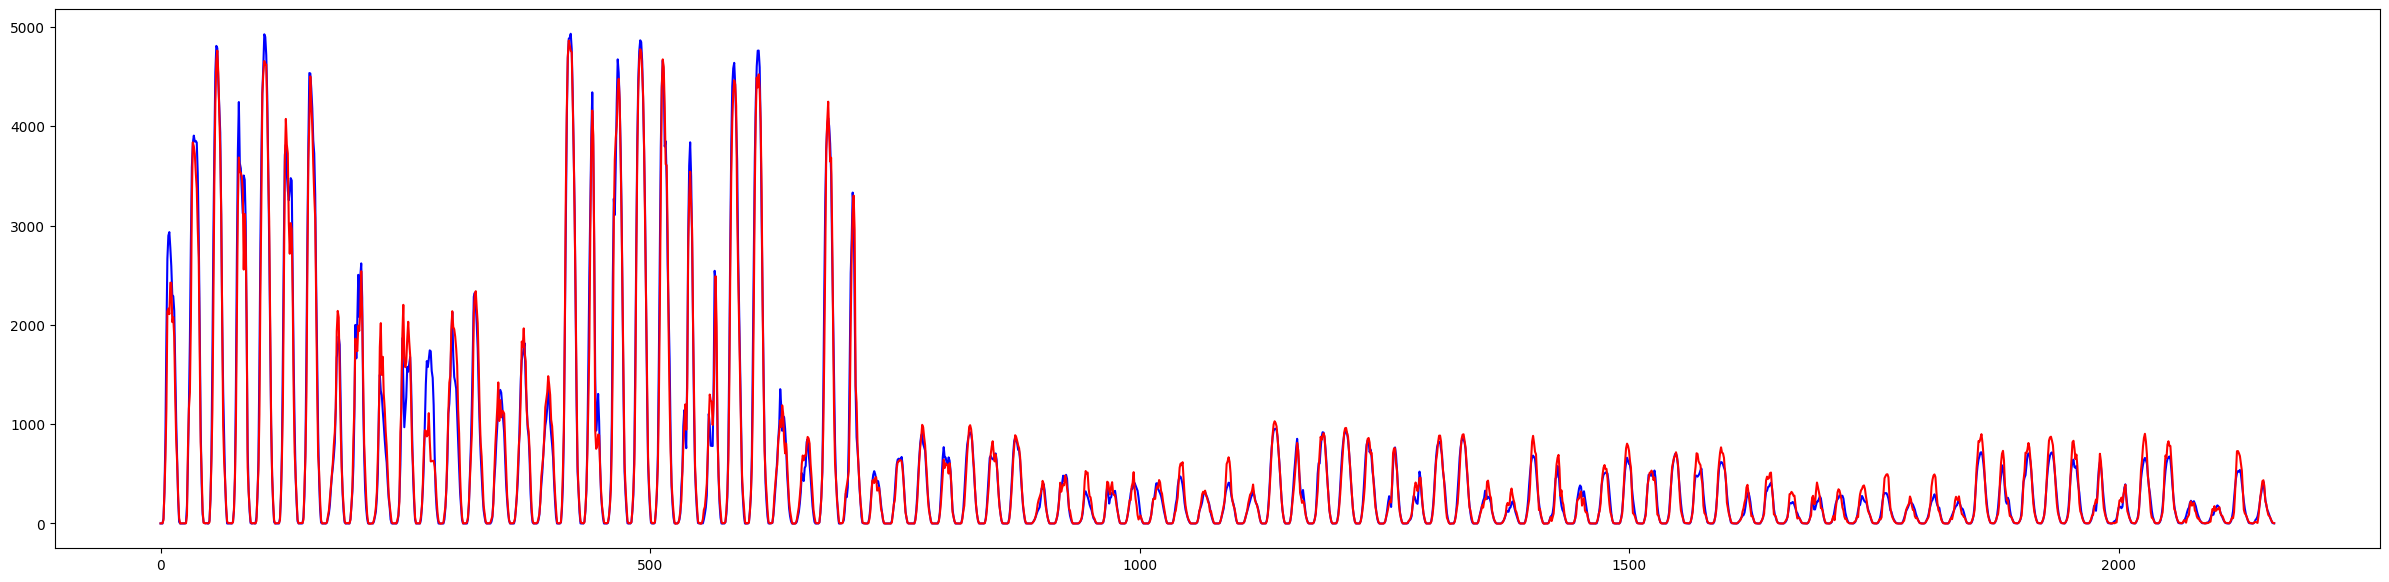

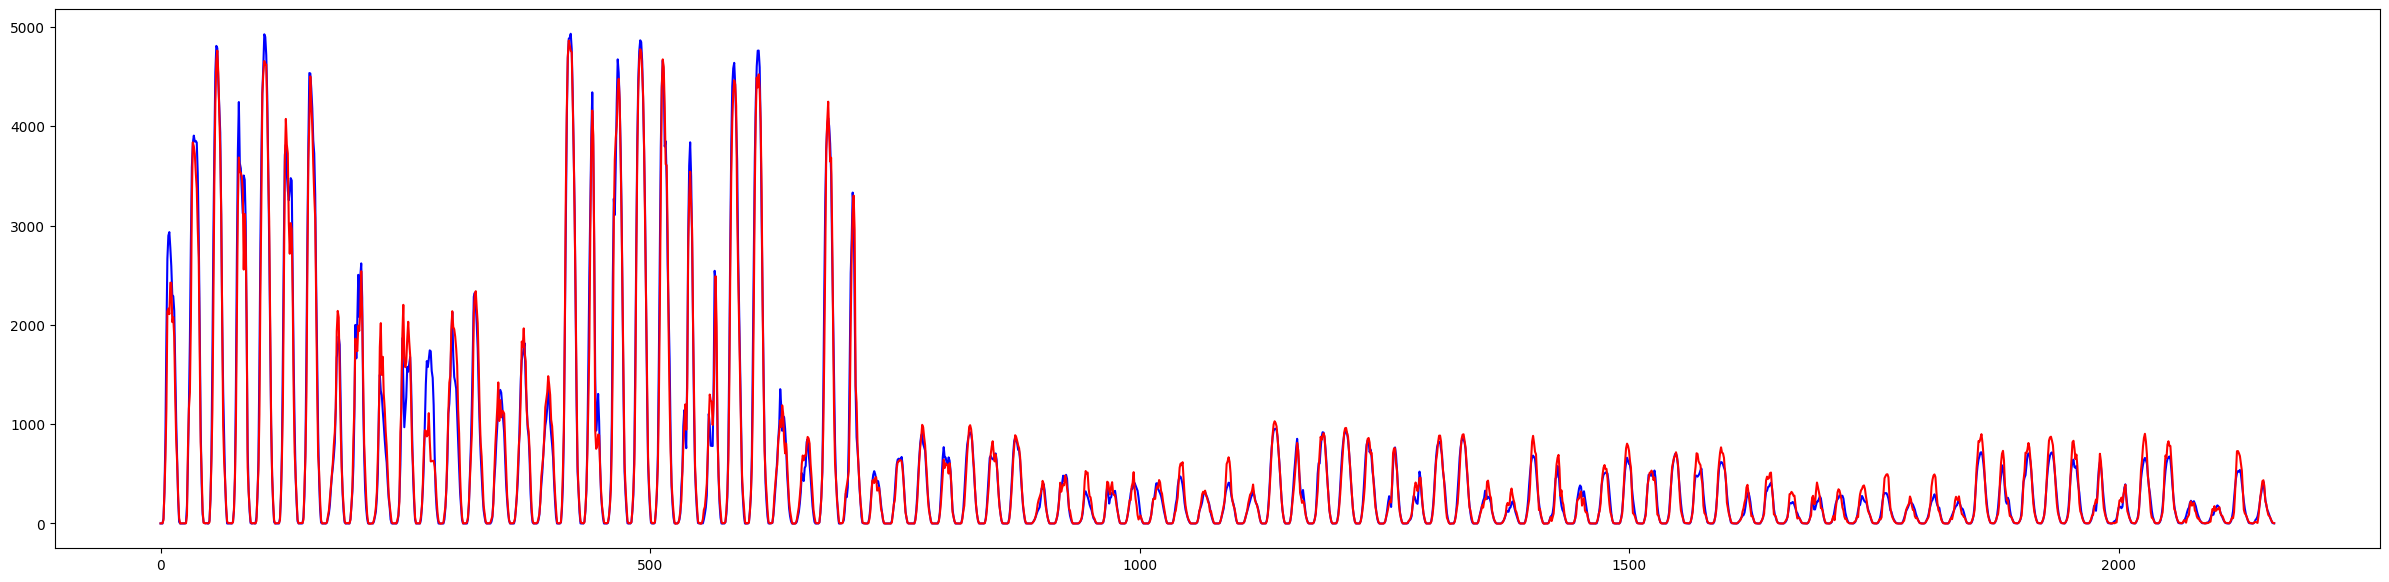

In [50]:
for prediction in prediction_list:
    plt.figure(figsize=(30, 7))
    plt.plot(catboost_predictions, 'b-')
    plt.plot(autogloun_predictions, 'r-')
    plt.show()

In [51]:
prediction_list = [np.mean(prediction_list, axis=0)]

## Postprocessing: Removing negative values and setting night time values to zero

In [52]:
def set_zero_in_time_range(data: pd.DataFrame, start_hour: int, end_hour: int):
        time_column = TIME
        if not pd.api.types.is_datetime64_any_dtype(data[time_column]):
            data[time_column] = pd.to_datetime(data[time_column])

        if start_hour <= end_hour:
            mask = data[time_column].dt.hour.between(start_hour, end_hour, inclusive='left')
        else:
            mask = (data[time_column].dt.hour >= start_hour) | (data[time_column].dt.hour <= end_hour)

        data.loc[mask, 'pv_measurement'] = 0
        return data

def set_zero_in_time(predictions: np.ndarray, start_hour: int, end_hour: int) -> np.ndarray:
    locations: list[LocationData] = [A, B, C]
    location_predictions: list[np.ndarray] = []

    segment_size = len(predictions) // len(locations)

    for i in range(len(locations)):
        # Calculate the start and end indices for each segment
        start_idx = i * segment_size
        end_idx = (i + 1) * segment_size

        # Extract the segment from predictions and append to location_predictions
        segment = predictions[start_idx:end_idx]
        location_predictions.append(segment)
        
    data_list = []
    for location, prediction in zip(locations, location_predictions):
        test_dates = location.test_data.index.values
        data = pd.DataFrame(data=prediction, index=test_dates, columns=[PV_MEASUREMENT])
        data = set_zero_in_time_range(data, start_hour, end_hour)
        data.append(data[PV_MEASUREMENT].to_numpy())
        
    return np.concatenate(data_list)

# Saving predictions

In [53]:
DATA_DIR = os.path.join(os.getcwd(), "data")


def create_csv(*prediction_list: np.ndarray) -> None:
    prediction_path: str = os.path.join(
        DATA_DIR,
        "predictions",
        time.strftime("%Y%m%d-%H%M%S") + ".csv",
    )

    output: np.ndarray = np.concatenate(prediction_list)
    output = output.clip(min=0, max=None)
    indexes = np.arange(0, len(output), 1, dtype=int)

    data = {
        "id": indexes,
        "prediction": output
    }

    dataframe: pd.DataFrame = pd.DataFrame(data)
    dataframe.to_csv(prediction_path, index=False)

In [54]:
create_csv(predictions)